In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

mean_occupation = np.zeros((24, 7, 2))
params = None
sweep_rate = np.zeros((7,))

path = "/home/jkambulo/projects/def-rgmelko/jkambulo/data/KZ_Data"
for folder in os.listdir(path):
    if not all(x.isnumeric() for x in folder.split('x')):
        continue
    
    nrows, ncols = [int(x) for x in folder.split('x')]
    if nrows != 12:
        continue
    
    for sweep_i,data_file in enumerate(os.listdir(os.path.join(path, folder))):
        with np.load(os.path.join(path,folder, data_file)) as f:
            # C = 5.420441132650757e6
            # Rb = (C / f['rabi_freq']) ** (1 / 6)
            # print(Rb, 1.15, Rb/1.15)
            # print(f['rabi_freq'], f['params'])
            # print('delta', f['rabi_freq']*np.array(f['params']))
            # print('omega', f['rabi_freq'])
            # print('a',1.15)
            
            # raise Exception()
            index = slice(None, None)
            if params is None:
                params = f['params']
            elif len(f['params']) > len(params):
                index = slice(None, None, 2)
            print(f['rydberg_data'].shape)

            sweep_rate[sweep_i] = f['sweep_rate']
            mean_occupation[:, sweep_i, 0] = np.mean(f['rydberg_data'][:,:,index,:], axis=(0,1,3))
            mean_occupation[:, sweep_i, 1] = np.std(np.mean(f['rydberg_data'][:,:,index,:], axis=(0,1)), axis=1)
            # print(f['rydberg_data'].shape, f['params'].shape, data_file)

(12, 12, 24, 500)
(12, 12, 24, 500)
(12, 12, 24, 500)
(12, 12, 24, 500)
(12, 12, 48, 1000)
(12, 12, 24, 500)
(12, 12, 24, 500)


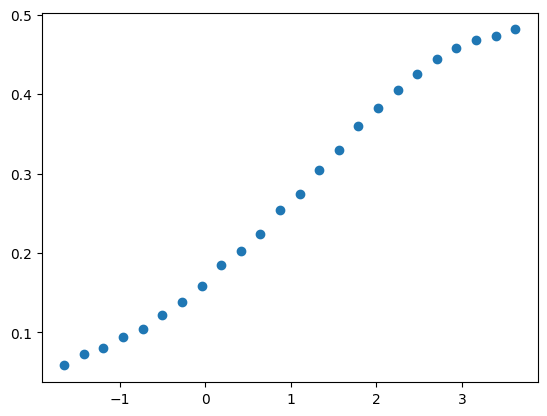

In [3]:
plt.scatter(params, mean_occupation[:,0,0])

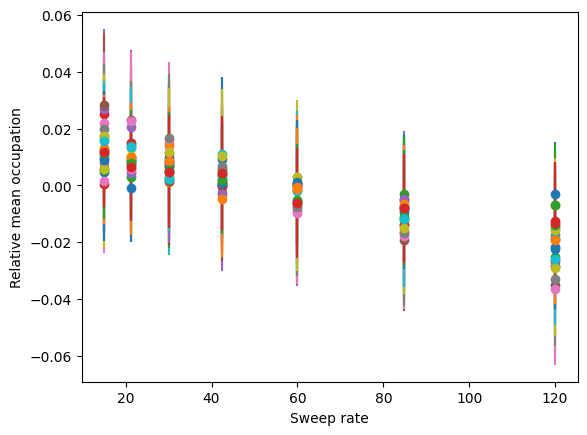

In [5]:
for i in range(24):
    plt.errorbar(sweep_rate, mean_occupation[i,:,0]-np.mean(mean_occupation[i,:,0]), yerr=mean_occupation[i,:,1], fmt='o', label=rf'$\Delta/\Omega={params[i]}$')
plt.xlabel('Sweep rate')
plt.ylabel('Relative mean occupation')
plt.show()

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import os
import json

mean_occupation = np.zeros((36, 2))
lattice_spacing = np.zeros((36,))

path = "/home/jkambulo/projects/def-rgmelko/jkambulo/data/square_scan"
i = 0
for file in os.listdir(path):
    if not file.endswith("results"):
        continue
    with open(os.path.join(path, file.replace('.results', '.json'))) as f_meta:
        
        with open(os.path.join(path, file),'r') as f:
            meta = json.load(f_meta)
            dic = json.load(f)
            lattice_spacing[i] = meta['lattice']['sites'][1][0]-meta['lattice']['sites'][0][0]
            shot_data = [np.mean(x['post_sequence']) for x in dic['shot_outputs']]
            mean_occupation[i,0] = np.mean(shot_data)
            mean_occupation[i,1] = np.std(shot_data)
    i += 1

Text(0, 0.5, 'Mean occupation')

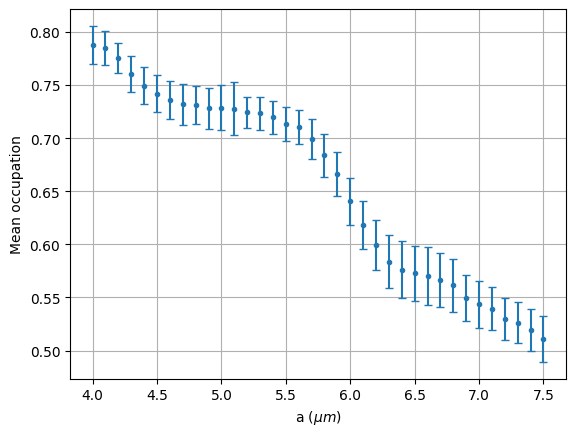

In [4]:

plt.errorbar(lattice_spacing*1e6, mean_occupation[:,0], yerr=mean_occupation[:,1], fmt='.', capsize=3)
plt.grid()
plt.xlabel(r'a ($\mu m$)')
plt.ylabel('Mean occupation')

In [6]:

%cd /project/6000317/jkambulo/code/qc-temp/transformer
from dataloader import QCTempDataset
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
delta = 3.5
rb = 1.1
N = 11
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(N,N), lattice="SquareLattice", Rb_per_a=rb, delta_per_omega=delta)

/project/6000317/jkambulo/code/qc-temp/transformer


In [7]:
batches = 50
batchsize = int(10_000_000/batches)
occupation = np.zeros((10_000_000, len(dataset.beta)))


def worker(i, batchsize, k):
    return np.mean(dataset.datasets[i][:,k*batchsize:(k+1)*batchsize], axis=0)
    
with Pool(processes=16) as pool:
    for i in range(len(dataset.beta)):
        occupation[:,i] = np.concatenate(pool.starmap(worker, [(i, batchsize, batch) for batch in range(batches)]))

# print(f"beta={beta}, {np.mean(occupation)}, {np.std(occupation)}")


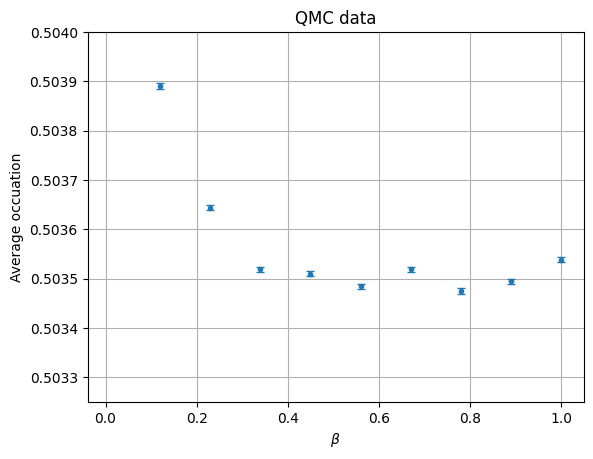

In [15]:
import matplotlib.pyplot as plt

plt.errorbar(dataset.beta, np.mean(occupation, axis=0), yerr=np.std(occupation, axis=0)/np.sqrt(occupation.shape[0]), fmt='.', capsize=3)
plt.xlabel(r'$\beta$')
plt.ylabel("Average occuation")
plt.title("QMC data")
plt.ylim([0.50325,0.504])
plt.grid()
plt.show()
